In [17]:
import numpy as np
np.random.seed(420)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

#preProcFeatsnew = np.load('./processed.files/labelled/featuresnew.npy')
preProcFeatsnew = np.load('./redfeatnew.npy')
preProcLabelsnew = np.load('./processed.files/labelled/labelsnew.npy')

#preProcFeats = np.load('./processed.files/labelled/featuresold.npy')
preProcFeats = np.load('./redfeatold.npy')
preProcLabels = np.load('./processed.files/labelled/labelsold.npy')

print preProcFeats.shape
print preProcFeatsnew.shape

(12398, 125)
(12398, 288)


In [18]:
clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

k_fold = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=420)

In [19]:
# #Binarise the classification
# y_train[y_train != 9] = 0
# y_test[y_test != 9] = 0

In [20]:
clf.fit(X_train, y_train)

prob_pos_old = clf.predict_proba(X_test)[:, 7]
y_test[y_test != 9] = 0
frac_pos_old, mean_pred_value_old = calibration_curve(y_test, prob_pos_old, n_bins=10)

In [21]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

In [22]:
# #Binarise the classification
# y_train[y_train != 9] = 0
# y_test[y_test != 9] = 0

In [23]:
clf.fit(X_train, y_train)

prob_pos = clf.predict_proba(X_test)[:, 7]
y_test[y_test != 9] = 0
frac_pos, mean_pred_value = calibration_curve(y_test, prob_pos, n_bins=10)

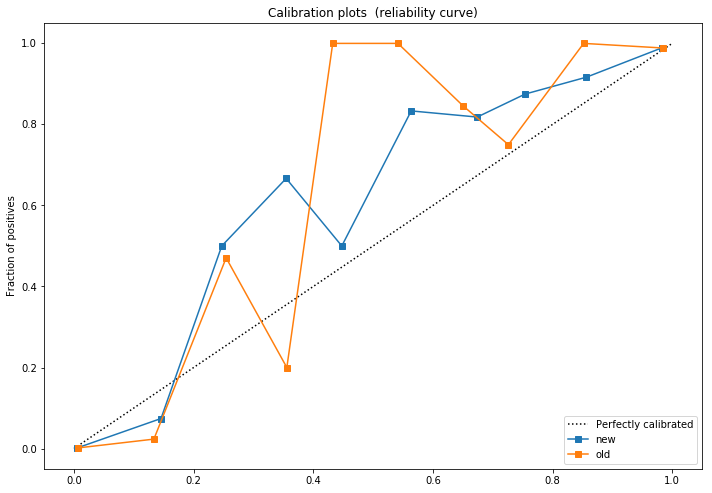

In [24]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_pred_value, frac_pos, "s-", label="new")
ax1.plot(mean_pred_value_old, frac_pos_old, "s-", label="old" )

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

plt.tight_layout()
plt.show()

### Training and calibration sets MUST be disjoint!

In [90]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeatsnew,\
                                                            preProcLabelsnew, test_size=0.25, random_state=420)

valfrac = 0.25
print y_train.shape, X_train.shape
size = y_train.flatten().size
frac = int(0.25*size)

X_valid, y_valid = X_train[frac:size], y_train[600:800]
X_train, y_train = X_train[:frac], y_train[:frac]
X_train_valid, y_train_valid = X_train[:frac], y_train[:frac]

# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
clf_probs9 = clf_probs[:,7]
clf_probsn9 = clf_probs[]
score = sklearn.metrics.log_loss(y_test, clf_probs)
print score

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
cal_clf = CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
cal_clf.fit(X_valid, y_valid)
cal_clf_probs = sig_clf.predict_proba(X_test)
cal_score = sklearn.metrics.log_loss(y_test, cal_clf_probs)
print cal_score

(2324,) (2324, 481)


ValueError: y_true and y_pred contain different number of classes 2, 8. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 9]